# Predicting Boston Housing Prices

## Getting Started
Our target with this project is to evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

By running the code cell below we'll load the Boston housing dataset, along with a few of the necessary Python libraries required for this project.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Calculating Statistics

In order to get familiarized with the data, we'll calculate a set of descriptive statistics. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In particular, we will calculate the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.

In [2]:
# Compute descriptive stats.

minimum_price = np.min(prices)

maximum_price = np.max(prices)

mean_price = np.mean(prices)

median_price = np.median(prices)

std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${:,.2f}".format(minimum_price))
print("Maximum price: ${:,.2f}".format(maximum_price))
print("Mean price: ${:,.2f}".format(mean_price))
print("Median price ${:,.2f}".format(median_price))
print("Standard deviation of prices: ${:,.2f}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


###  Feature Observation
As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

Just by *intuition* I would think that LSTAT and PTRATIO have a bigger impact on our target feature, MEDV, because they define the "goodness" and "appeal" of a neighborhood. 

More specifically, I'd say LSTAT is negative correlated with MEDV. This is, when LSTAT increases, MEDV actually decreases, because an increment of "lower class" citizens in a particular neighborhood would most likely affect its status among the Boston inhabitants.

I also think that PTRATIO is negative correlated with MEDV. So, for instance, it is sensible to think that a neighborhood with a 10 students per teacher provides a better education to its residents' children than one where every teacher has to attend 30 kids (although this assumption could perfectly be subject of a different problem :)).

Finally, I would say that RM is positively correlated with MEDV, which means that an increase in RM also increases MEDV. Although, unfortunatelly, we do not have access to the area of the house in square meters/feet, it's sensible to assume that a house with more bedrooms is also a bigger house, hence its worth would increase.

### Checking our _intuition_

Let's see if what we stated in the last cell is true. Let's plot three scatter plots, one for each feature related with `prices`. 

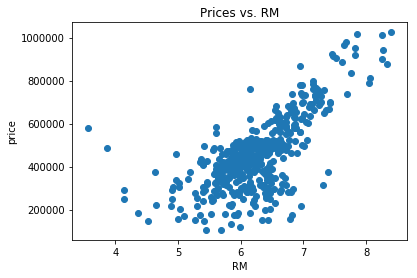

In [3]:
import matplotlib.pyplot as plt

def scatter_plot(x, y, title, x_label, y_label):
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.scatter(x, y)
    
scatter_plot(features['RM'], prices, "Prices vs. RM", "RM", "price")

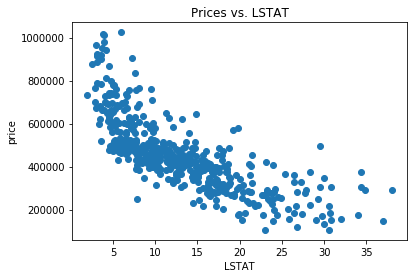

In [4]:
scatter_plot(features['LSTAT'], prices, "Prices vs. LSTAT", "LSTAT", "price")

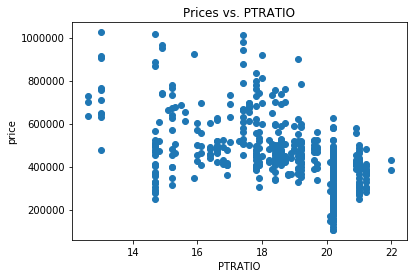

In [5]:
scatter_plot(features['PTRATIO'], prices, "Prices vs. PTRATIO", "PTRATIO", "price")

It seems that RM and prices are, in fact, positively correlated. Also, LSTAT are definitely negatively correlated. However, the points in the last plot are very scattered, so it seems that PTRATIO and prices share a very low correlation factor (if any).

----

## Developing a Model
Let's now develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in our predictions.

### Defining a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, we will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify our model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

In [6]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    score = r2_score(y_true, y_predict)
    
    return score

###  Goodness of Fit
Let's assume for a moment that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

Let's check this model's coefficient of determination using the `performance_metric` function.

In [7]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


According to the output of our performance_metric function, the model captures pretty well the variance of the output variable, by explaining about 92.3% of it from the input features.

### Shuffle and Split Data
Let's now take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

In [8]:
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=42)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


### Benefit of Training and Testing

Splitting our data into training and testing chunks allow us to separate a portion of it for measuring the performance of our model in an unseen dataset. This way we can detect if our model is underfitting (its performance on the training set is poor) or overfitting to the training set (its performance on the test set is considerably worse than in the training set).

----

## Analyzing Model Performance
In this third section of the project, we'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, we'll investigate one particular algorithm (Decision Tree) with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing our model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Let's note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.

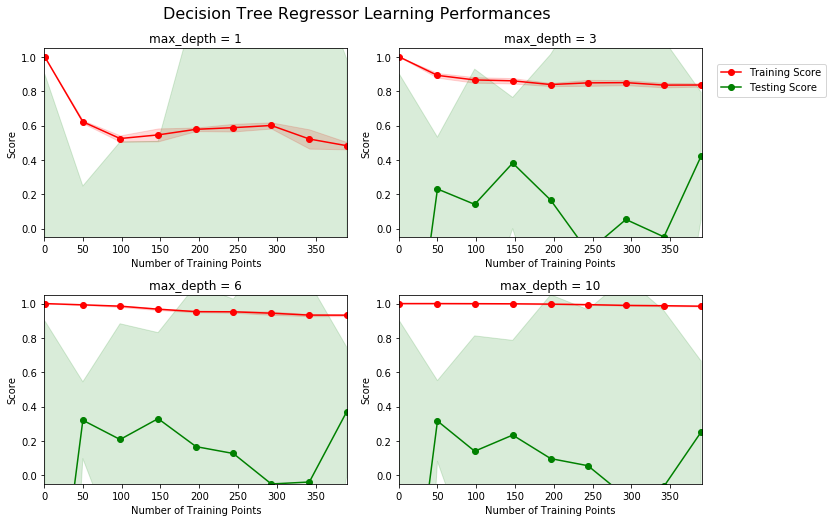

In [9]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Learning the Data

Let's take the graph corresponding to a model with depth = 10. At first, with a few data points the training curve is already at 100% accuracy. What does this mean? Given that the model is too complex for our relatively simple data, it catched all the details of the few points it has been trained on. On the other hand, the test curve stays around 60-70% almost invariably despite more data being fed to the model. The same trends mantains for both curves for 50, 100, 150, 200 up to 300 points. This leads us to think that more data won't make any difference because the model has high variance, meaning it pays too much attention to every little detail of the data, so it won't ever generalize well (will always do poorly on unseen data, i.e. test set). Our model is just too complex.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

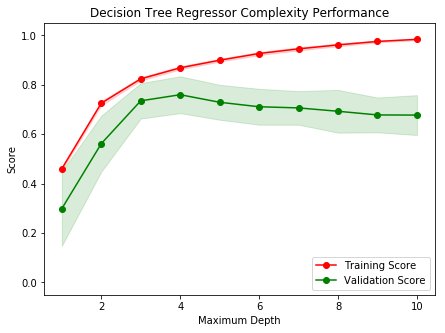

In [10]:
vs.ModelComplexity(X_train, y_train)

### Bias-Variance Tradeoff

High bias is a sign of underfitting (model is not complex enough to pick up the nuances in the data) and high variance is a sign of overfitting(model is by-hearting the data and cannot generalize well). Think about which model(depth 1 or 10) aligns with which part of the tradeoff.

When the model has minimum depth (1) it underfits the data (only achieves about 30% accuracy on the validation set and 42% on the training set, worse than random guessing). This means that our model suffer of **high bias**, so it doesn't pay sufficient attention to the data and doesn't capture its nuances. In other words, it oversimplifies the data. On the other hand, when the model is way more complex (depth = 10), it does remarkably well on the training set (about 99.99% accuracy) but way worse on the validation set (about 62% accuracy), which is a clear sign that our model is too complex for the data, so it has overfit to it and it is not able to generalize well. Another way to put is: Our model has high variance, which makes it too sensible to variations in the data, so when it encounters an unseen example, it tends to perform poorly.

### Best-Guess Optimal Model

In the curves above it seems that the optimal model has depth = 4, because it hits the best accuracy on the validation set (about 71 %)

-----

## Evaluating Model Performance
In this final section of the project, we will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

###  Grid Search

One of the hardest task in machine learning is selecting a good model, and after that, tuning it to achieve its optimal state! Given that some algorithms may have more knobs to tune, the search space is remarkably complex to apply a guess-and-check method. So, in order to automate this task, we can define a grid of parameters we would like to explore, and finally we pick the combination that provides the best results. An example of a grid search for a decision tree might be:

{'max_depth': (1, 2, 5, 10), 'splitter': ('best', 'random')}

This means that our grid search algorithm will train a DecisionTree with parameters max_depth=1 and splitter=best, and then a DecisionTree with max_depth=2 and splitter=best and so on until it has explored all the possible parameter combinations.

### Cross-Validation

K-fold cross validation is a technique used to maximize the usage of our data. The K is a parameters that means we'll split our dataset into K chunks, where K-1 chunks will form the training set and the remaining chunk will comprise the validation set. Then, we'll train a model on this training set and then we'll test it against the validation set. We'll perform this process K times, which means we'll train K models and average its results. This is useful for Grid Search because the algorith will be less likely to overfit. Why? Well, because we have used all of our data points for cross-validation exactly once, so it has more "examples" to test its performance.

### Fitting a Model

In [11]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0).get_n_splits(X.shape[0])

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': range(1, 11)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**.

### Optimal Model

In [12]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


### Predicting Selling Prices
Let's imagine for a second that we were a real estate agent in the Boston area looking to use this model to help price homes owned by our clients that they wish to sell. We have collected the following information from three of our clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

* What price would we recommend each client sell his/her home at? 
* Do these prices seem reasonable given the values for the respective features? 

In [13]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $403,025.00
Predicted selling price for Client 2's home: $237,478.72
Predicted selling price for Client 3's home: $931,636.36


Let's take a look at the descriptive statistics of each feature:

In [14]:
features.describe()

,RM,LSTAT,PTRATIO
count,489.000000,489.000000,489.000000
mean,6.240288,12.939632,18.516564
std,0.643650,7.081990,2.111268
min,3.561000,1.980000,12.600000
25%,5.880000,7.370000,17.400000
50%,6.185000,11.690000,19.100000
75%,6.575000,17.120000,20.200000
max,8.398000,37.970000,22.000000


Let's break down each case:

* `Client 1: RM = 5, LSTAT = 17 % and PTRATIO = 15 %. Predicted price = $403,025.`
Although the number of rooms is below average, the PTRATIO is below average for a bit more than one standard deviation, which is a nice plus. Unfortunately the LSTAT feature is above average, meaning that this house is in an area a bit poorer than the average. I would advise Client 1 to sell his or her house at the predicted price given that is in disadvantage with the average houses in our dataset. Also, our model seems to have noticed this, because the predicted price is not too far below the average: $454,342.94.

* `Client 2: RM = 4, LSTAT = 32%, PTRATIO = 22%. Predicted price: $237,478.72.` Unfortunately, this client has the worst deal because he has a really small house (at least in terms of rooms, given that the the minimum is 3.5) in a considerably low-income area (LSTAT of 32% which if less than one standard deviation away from the top: 37.97%) with the worst ratio of students per teacher: 22%. I would advise client two to try for less than what our optimistic model predicted (something at least $50,000 less).

* `Client 3: RM = 8, LSTAT = 3%, PTRATIO = 12%. Predicted price $931,636.36`. This client has the best deal. With a house with the max number of rooms in our data set, located in a fairly well-off area (an LSTAT very close to the minimum which is approximately 2%) and the best students-per-teacher ratio, he or her could actually ask for more money that our model suggests. I'd say that they could try their luck and ask for at least `$65,000.00` more than the $931,636.36 the algorithm produced. 

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

In [15]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $411,417.39
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $402,531.82
Trial 10: $413,700.00

Range in prices: $29,438.89


### Applicability

I think that in order for the model to be used in a real world setting it should be improved, mostly because our data seems to be insufficient and outdated (the city of Boston surely has changed a lot in four decades). Also, some other features like square feet of the plot area and presence areas like a big backyard or a pool might increase the price tag of the house.

Another factor to consider is that real estate prices varies a lot from one city or area to another, so our model might be of little use in a small town like Louisville. 

Despite all of this, in my opinion, our model is a few tweaks away of being a great resource for a real estate agent or anyone interested in the topic, and has the potential of giving a real edge to the one who uses it to make better choices :)